In [1]:
import os
os.chdir("/project/validating_attribution_techniques/")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [23]:
from juneja.validation_pipeline.preprocess import img_to_tensor
from juneja.validation_pipeline.metrics import normalize, match_hist, normalize_map, SIM, CC, NSS
from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from shardul.ScoreCAM.utils.visualize import visualize, reverse_normalize
from shardul.ScoreCAM.utils.imagenet_labels import label2idx, idx2label
from torchvision.models import resnet50, resnet18, vgg16, inception_v3
from torchvision.models.inception import Inception3


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


In [24]:
os.chdir("/project/validating_attribution_techniques/torchCAM")
from torchcam.methods.gradient import SmoothGradCAMpp, GradCAMpp, GradCAM, LayerCAM
from torchcam.methods.activation import ScoreCAM
from torchcam.utils import overlay_mask

In [25]:
os.chdir("/project/validating_attribution_techniques/")

In [26]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image 
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [193]:
!nvidia-smi

Fri Oct 27 23:57:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 31%   54C    P2              79W / 250W |   1073MiB / 11264MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
classes = get_imagenet_classes()

In [29]:
#Load all images
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)

In [30]:
#Load perturbed images array which contains array of arrays so at 'i' location of 
#perturbed_images_array we contain all occluded images of 'i' image
perturbed_images_array = np.load('/project/validating_attribution_techniques/shardul/data/occlusion/Images_20.npy')

In [43]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
# model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
model_gpu = resnet50(pretrained=True).to(device).eval()
model_resnet50 = resnet50(pretrained=True).eval()
model_resnet18 = resnet50(pretrained=True).eval()
model_vgg = vgg16(pretrained=True).eval()
model_inception3 = inception_v3(pretrained=True).eval()
# model_resnet50 = resnet50(pretrained=True).to(device).eval()
# model_resnet18 = resnet50(pretrained=True).to(device).eval()
# model_vgg = vgg16(pretrained=True).to(device).eval()
# model_inception3 = inception_v3(pretrained=True).to(device).eval()
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model_gpu.eval()

In [44]:
target_layer = model_gpu.layer4[1].conv2
classes1 = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

In [45]:
resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

scorecam_wrapped_model = ScoreCAM(model_gpu, target_layer)
gradcam_wrapped_model = GradCAM(model_gpu, target_layer)

In [46]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [47]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [48]:
def wasserstein_distance(cam, perturbed_cam, method):
    # Ensure that the tensors have the same shape
    if method == "GradCAM":
        emd = EMD(np.reshape(cam.numpy(),(10,10)), np.reshape(perturbed_cam.numpy(),(10,10)), 1)
        return emd[0]
    elif method == "ScoreCAM":
        emd = EMD(np.reshape(cam.numpy(),(300,300)), np.reshape(perturbed_cam.numpy(),(300,300)), 1)
        return emd[0]
    elif method == "GradCAMpp":
        cam = np.where(cam > 0, cam, 1e-5)
        perturbed_cam = np.where(perturbed_cam > 0, perturbed_cam, 1e-5)
        emd = EMD(np.reshape(cam, (10, 10)), np.reshape(perturbed_cam, (10, 10)), 1)
        return emd[0]
def calculate_metrics(cam, perturbed_cam, method):
    sim = SIM(cam, perturbed_cam)
    cc = CC(cam, perturbed_cam)
    nss = NSS(cam, perturbed_cam)
#     auc_judd = AUC_Judd(cam, perturbed_cam)
#     auc_borji = AUC_Borji(cam, perturbed_cam)
#     emd = wasserstein_distance(cam, perturbed_cam, method)
    return sim, cc, nss

In [49]:
img_idx = 3 #Yet to start

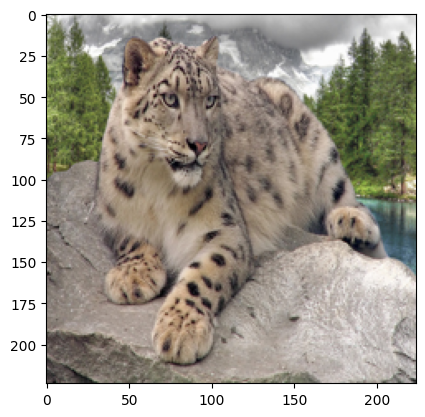

In [50]:
imshow(Image.fromarray((images[img_idx])))

In [39]:
original_image = Image.fromarray((images[img_idx]).astype(np.uint8))
input_tensor = resnet_transform(original_image).unsqueeze(0).to(device)

# LayerCAM

In [70]:
layer_original_image1 = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
layer_original_image = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# plt.imshow(original_image)
layer_input_tensor = resnet_transform(layer_original_image1).unsqueeze(0).to(device)
# layer_input_tensor = normalize(resize(layer_original_image, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [71]:
# img = Image.fromarray((images[img_idx]))
# img = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# # Preprocess it for your chosen model
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
layercam_extractor = LayerCAM(model_gpu, target_layer)
# with LayerCAM(model) as layercam_extractor:  
    # Preprocess your data and feed it to the model
layercam_out = model_gpu(layer_input_tensor)
    # Retrieve the CAM by passing the class index and the model output
layercam_activation_map = layercam_extractor(layercam_out.squeeze(0).argmax().item(), layercam_out)

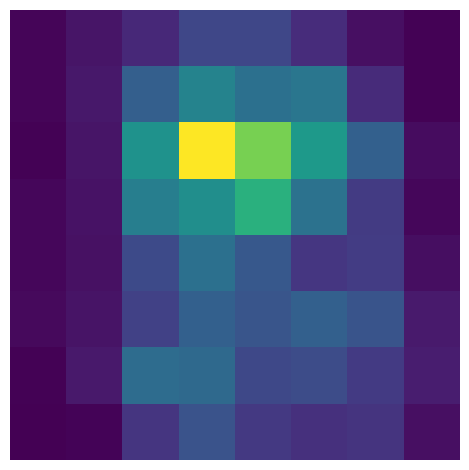

In [72]:
plt.imshow(layercam_activation_map[0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

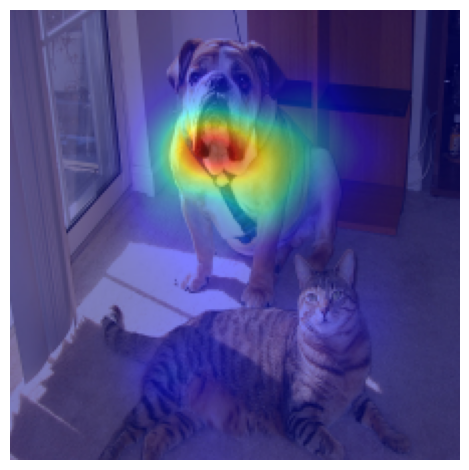

In [73]:
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(layer_original_image), to_pil_image(layercam_activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [74]:
# Apply softmax to calculate class probabilities
layer_probs = torch.softmax(layercam_out, dim=1)

# Get the class with the highest probability for each input
layer_pred_class = torch.argmax(layer_probs, dim=1)
layer_probs = layer_probs.detach().cpu().numpy()

# To extract the class ID and probability for the first input (if it's a batch):
layer_class_id = layer_pred_class[0].item()
layer_probability = layer_probs[0, layer_class_id].item()

In [75]:
layercam_mask =  layercam_activation_map[0].cpu().numpy().squeeze(0)

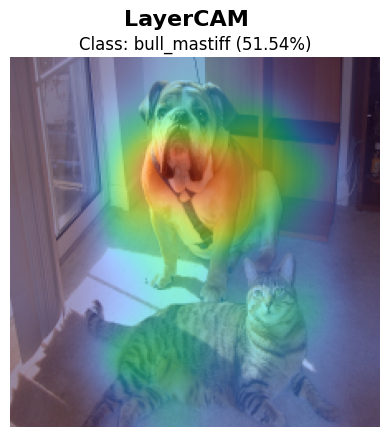

In [77]:
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.axis('off')

fig.suptitle("LayerCAM", fontsize=16, fontweight="bold")
visualize_saliency_overlay(plt.gca(), layer_original_image1, layercam_mask, layer_probs, layer_class_id, classes);
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Saliency_Gen/base/LayerCAM.png")


# SmoothGradCAM++,

In [78]:
original_image1 = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
original_image = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# plt.imshow(original_image)
# smooth_input_tensor = resnet_transform(original_image).unsqueeze(0).to(device)
smooth_input_tensor = normalize(resize(original_image, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [79]:
from torchvision.models import resnet50
# from torchcam.methods import SmoothGradCAMpp

model = resnet50(pretrained=True).eval()
# img = Image.fromarray((images[img_idx]))
# img = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# # Preprocess it for your chosen model
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
cam_extractor = SmoothGradCAMpp(model)
# with SmoothGradCAMpp(model, target_layer) as cam_extractor:
    # Preprocess your data and feed it to the model
out = model(smooth_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
smoothgradcam_mask = cam_extractor(out.squeeze(0).argmax().item(), out)

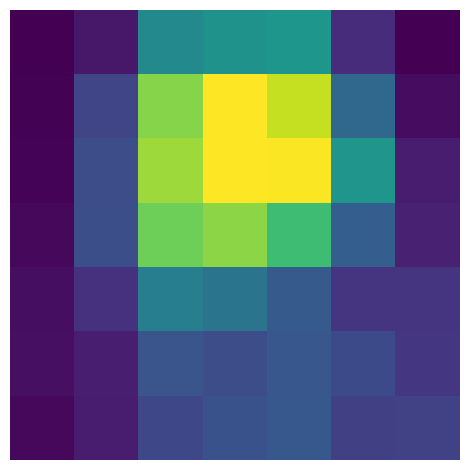

In [80]:
plt.imshow(smoothgradcam_mask[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

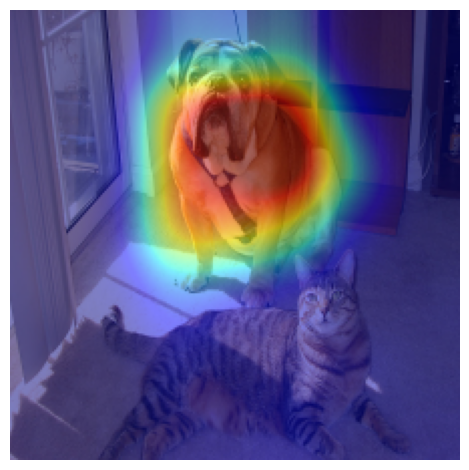

In [81]:
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(original_image), to_pil_image(smoothgradcam_mask[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [82]:
# Apply softmax to calculate class probabilities
probs = torch.softmax(out, dim=1)
smooth_probs = probs.detach().cpu().numpy()
# Get the class with the highest probability for each input
pred_class = torch.argmax(probs, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
class_id = pred_class[0].item()
probability = probs[0, class_id].item()


In [83]:
smoothgradcam_mask =  smoothgradcam_mask[0].cpu().numpy().squeeze()
# smoothgradcam_probs = out.detach().cpu().numpy()

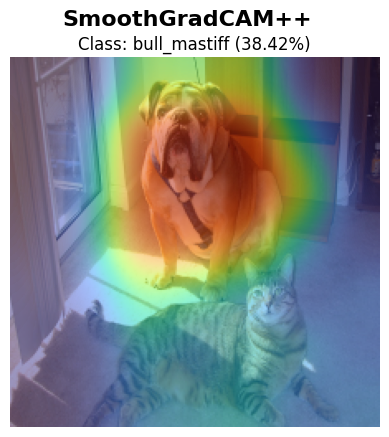

In [84]:
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.axis('off')
fig.suptitle("SmoothGradCAM++", fontsize=16, fontweight="bold")
visualize_saliency_overlay(plt.gca(), original_image1, smoothgradcam_mask, smooth_probs, class_id, classes);
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Saliency_Gen/base/SmoothGradCAMpp.png")


In [83]:
# fig, axes = plt.subplots(ncols=3, nrows=1)

# fig.set_figwidth(12)
# # fig.set_layout_engine('tight'),
# fig.suptitle("GradCAM vs ScoreCAM vs SmoothGradCAM++", fontsize=16, fontweight="bold",y=0.54)
# fig.set_figheight(80)
# visualize_saliency_overlay(axes[0], Image.fromarray((images[img_idx])), gradcam_mask, gradcam_probs, gradcam_idx, classes);
# visualize_saliency_overlay(axes[1], Image.fromarray((images[img_idx])), scorecam_mask, scorecam_probs, scorecam_idx, classes);
# visualize_saliency_overlay(axes[2], Image.fromarray((images[img_idx])), smoothgradcam_mask, smoothgradcam_probs, scorecam_idx, classes);

# GradCAM

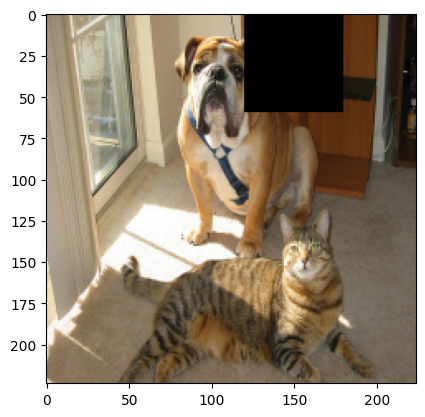

In [186]:
# original_image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
original_image = Image.open('/project/validating_attribution_techniques/shardul/data/Doc/Occlusion/original/Occlusion_60_2.png')
imshow(original_image)
gradpp_input_tensor = resnet_transform(original_image).unsqueeze(0).to(device)

In [187]:

# img = Image.fromarray((images[img_idx]))
# img = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# # Preprocess it for your chosen model
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
gradcampp_extractor = GradCAM(model_gpu, target_layer)
  # Preprocess your data and feed it to the model
gradcampp_out = model_gpu(gradpp_input_tensor)
    # Retrieve the CAM by passing the class index and the model output
gradcampp_activation_map = gradcampp_extractor(gradcampp_out.squeeze(0).argmax().item(), gradcampp_out)

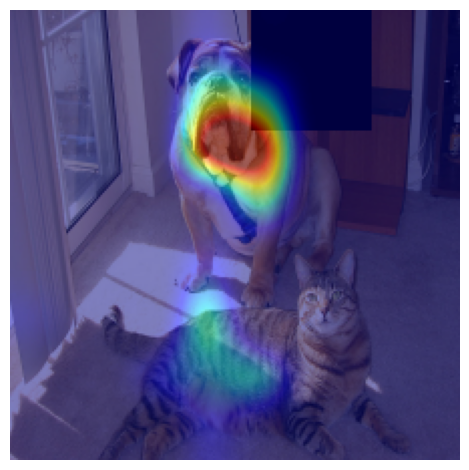

In [188]:
# Resize the CAM and overlay it
# result = overlay_mask(to_pil_image(images[img_idx]), to_pil_image(gradcampp_activation_map[0].squeeze(0), mode='F'), alpha=0.5)
result = overlay_mask(original_image, to_pil_image(gradcampp_activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [190]:
# Apply softmax to calculate class probabilities
probs_gradpp = torch.softmax(gradcampp_out, dim=1)

# Get the class with the highest probability for each input
gradpp_pred_class = torch.argmax(probs_gradpp, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
gradpp_class_id = gradpp_pred_class[0].item()
gradpp_probability = probs_gradpp[0, gradpp_class_id].item()

In [191]:
gradcampp_mask =  gradcampp_activation_map[0].cpu().numpy().squeeze()

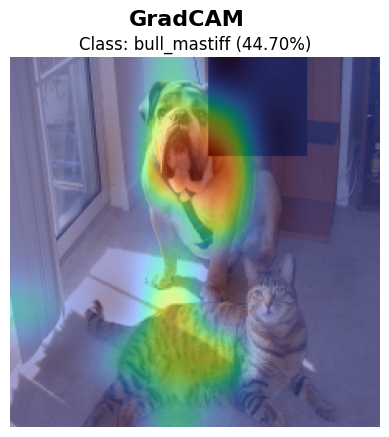

In [192]:
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.axis('off')
fig.suptitle("GradCAM", fontsize=16, fontweight="bold")
visualize_saliency_overlay(plt.gca(), original_image, gradcampp_mask, gradpp_probability, gradpp_class_id, classes);
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Occlusion/saliency/Occlusion_60_2.png")

# ScoreCAM

In [194]:
score_original_image1 = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
score_original_image = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# plt.imshow(original_image)
# score_input_tensor = resnet_transform(score_original_image1).unsqueeze(0).to(device)
score_input_tensor = normalize(resize(layer_original_image, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [97]:
# scorecam_extractor = ScoreCAM(model_gpu, target_layer)
with ScoreCAM(model_resnet50) as scorecam_extractor:  
    # Preprocess your data and feed it to the model
    scorecam_out = model_resnet50(score_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    scorecam_activation_map = scorecam_extractor(scorecam_out.squeeze(0).argmax().item(), scorecam_out)

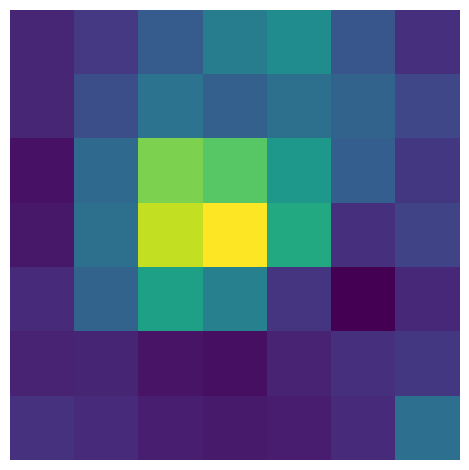

In [101]:
plt.imshow(scorecam_activation_map[0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

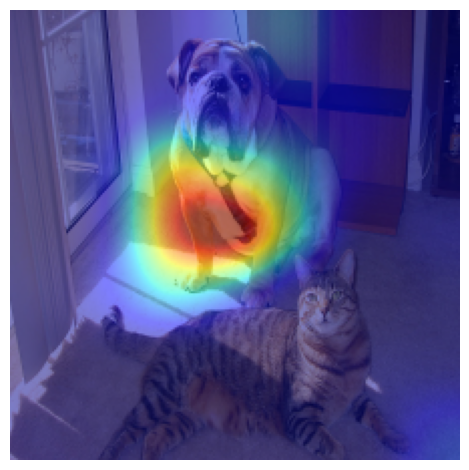

In [103]:
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(score_original_image), to_pil_image(scorecam_activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [98]:
# Apply softmax to calculate class probabilities
score_probs = torch.softmax(scorecam_out, dim=1)

# Get the class with the highest probability for each input
score_pred_class = torch.argmax(score_probs, dim=1)
score_probs = score_probs.detach().cpu().numpy()

# To extract the class ID and probability for the first input (if it's a batch):
score_class_id = score_pred_class[0].item()
score_probability = score_probs[0, score_class_id].item()
scorecam_mask =  scorecam_activation_map[0].cpu().numpy().squeeze(0)

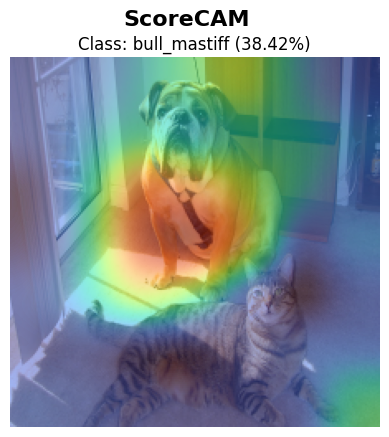

In [100]:
fig, axes = plt.subplots(ncols=1, nrows=1)
axes.axis('off')

fig.suptitle("ScoreCAM", fontsize=16, fontweight="bold")
visualize_saliency_overlay(plt.gca(), score_original_image1, scorecam_mask, score_probs, score_class_id, classes);
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Saliency_Gen/base/ScoreCAM.png")

# 4 models using GradCAM

In [115]:
original_image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
original_image1 = read_image("/project/validating_attribution_techniques/commons/examples/input.png")
# plt.imshow(original_image)
# smooth_input_tensor = resnet_transform(original_image).unsqueeze(0).to(device)
gradpp_input_tensor = normalize(resize(original_image1, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

### ResNet50

In [53]:
# gradcampp_extractor_res50 = GradCAM(model_resnet50)
  # Preprocess your data and feed it to the model
with GradCAM(model_resnet50) as gradcampp_extractor_res50:
    gradcampp_out_res50 = model_resnet50(gradpp_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    gradcampp_activation_res50 = gradcampp_extractor_res50(gradcampp_out_res50.squeeze(0).argmax().item(), gradcampp_out_res50)

In [54]:
# Apply softmax to calculate class probabilities
probs_gradpp_res50 = torch.softmax(gradcampp_out_res50, dim=1)

# Get the class with the highest probability for each input
gradpp_pred_class_res50 = torch.argmax(probs_gradpp_res50, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
gradpp_class_id_res50 = gradpp_pred_class_res50[0].item()
gradpp_probability_res50 = probs_gradpp_res50[0, gradpp_class_id_res50].item()
gradcampp_mask_res50 =  gradcampp_activation_res50[0].cpu().numpy().squeeze()

### ResNet18

In [55]:
# gradcampp_extractor_res18 = GradCAM(model_resnet18)
with GradCAM(model_resnet18) as gradcampp_extractor_res18:
  # Preprocess your data and feed it to the model
    gradcampp_out_res18 = model_resnet18(gradpp_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    gradcampp_activation_res18 = gradcampp_extractor_res18(gradcampp_out_res18.squeeze(0).argmax().item(), gradcampp_out_res18)

In [56]:
# Apply softmax to calculate class probabilities
probs_gradpp_res18 = torch.softmax(gradcampp_out_res18, dim=1)

# Get the class with the highest probability for each input
gradpp_pred_class_res18 = torch.argmax(probs_gradpp_res18, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
gradpp_class_id_res18 = gradpp_pred_class_res18[0].item()
gradpp_probability_res18 = probs_gradpp_res18[0, gradpp_class_id_res18].item()
gradcampp_mask_res18 =  gradcampp_activation_res18[0].cpu().numpy().squeeze()

### VGG16

In [57]:
# gradcampp_extractor_vgg = GradCAM(model_vgg)
with GradCAM(model_vgg) as gradcampp_extractor_vgg:
  # Preprocess your data and feed it to the model
    gradcampp_out_vgg = model_vgg(gradpp_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    gradcampp_activation_vgg = gradcampp_extractor_vgg(gradcampp_out_vgg.squeeze(0).argmax().item(), gradcampp_out_vgg)

In [58]:
# Apply softmax to calculate class probabilities
probs_gradpp_vgg = torch.softmax(gradcampp_out_vgg, dim=1)

# Get the class with the highest probability for each input
gradpp_pred_class_vgg = torch.argmax(probs_gradpp_vgg, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
gradpp_class_id_vgg = gradpp_pred_class_vgg[0].item()
gradpp_probability_vgg = probs_gradpp_vgg[0, gradpp_class_id_vgg].item()
gradcampp_mask_vgg =  gradcampp_activation_vgg[0].cpu().numpy().squeeze()

### InceptionV3

In [59]:
# gradcampp_extractor_iv3 = GradCAM(model_inception3)
with GradCAM(model_inception3) as gradcampp_extractor_iv3:
  # Preprocess your data and feed it to the model
    gradcampp_out_iv3 = model_inception3(gradpp_input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    gradcampp_activation_iv3 = gradcampp_extractor_iv3(gradcampp_out_iv3.squeeze(0).argmax().item(), gradcampp_out_iv3)

In [60]:
# Apply softmax to calculate class probabilities
probs_gradpp_iv3 = torch.softmax(gradcampp_out_iv3, dim=1)

# Get the class with the highest probability for each input
gradpp_pred_class_iv3 = torch.argmax(probs_gradpp_iv3, dim=1)

# To extract the class ID and probability for the first input (if it's a batch):
gradpp_class_id_iv3 = gradpp_pred_class_iv3[0].item()
gradpp_probability_iv3 = probs_gradpp_iv3[0, gradpp_class_id_iv3].item()
gradcampp_mask_iv3 =  gradcampp_activation_iv3[0].cpu().numpy().squeeze()

### Visualisation

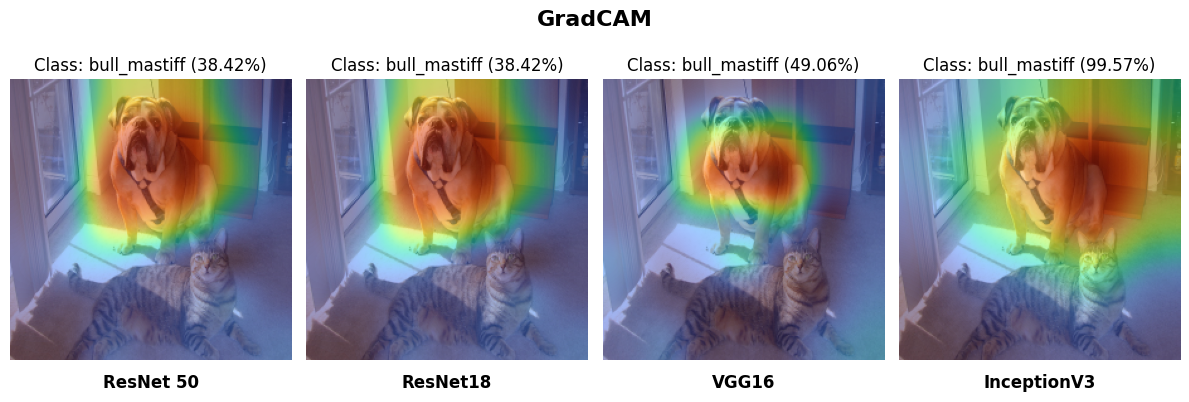

In [106]:
# fig, axes = plt.subplots(ncols=2, nrows=1)
fig, axes = plt.subplots(ncols=4, nrows=1)

fig.set_figwidth(12)
fig.set_layout_engine('tight')
fig.suptitle("GradCAM", fontsize=16, fontweight="bold",y=0.9)
# fig.set_figheight(40)
# Turn off the axis for each subplot
for ax in axes:
    ax.axis('off')
# Titles for each subplot
titles = ["ResNet 50", "ResNet18", "VGG16", "InceptionV3"]

visualize_saliency_overlay(axes[0], original_image, gradcampp_mask_res50, gradpp_probability_res50, gradpp_class_id_res50, classes);
visualize_saliency_overlay(axes[1], original_image, gradcampp_mask_res18, gradpp_probability_res18, gradpp_class_id_res18, classes);
visualize_saliency_overlay(axes[2], original_image, gradcampp_mask_vgg, gradpp_probability_vgg, gradpp_class_id_vgg, classes);
visualize_saliency_overlay(axes[3], original_image, gradcampp_mask_iv3, gradpp_probability_iv3, gradpp_class_id_iv3, classes);
# Modify this part to add unique titles for each subplot
for i, ax in enumerate(axes):
    # Call visualize_saliency_overlay with the necessary parameters
    # heatmap = visualize_saliency_overlay(ax, original_image, gradcampp_mask, gradpp_probability, gradpp_class_id, classes)
    ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Saliency_Gen/base/Models_GradCAM.png")


# Applying_Patch

In [109]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [122]:
patch_size = 60
original = np.array(original_image)
# original.shape
gen_occlu_images = generate_img_occlusion_list_no_saliency(original, patch_size)
np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Occlusion/Occlusion_{patch_size}.npy", gen_occlu_images)

In [123]:
sample_occlu_imgs = np.load(f"/project/validating_attribution_techniques/shardul/data/Doc/Occlusion/Occlusion_{patch_size}.npy")

In [126]:
for i in range(len(sample_occlu_imgs)):
    image = Image.fromarray((sample_occlu_imgs[i] * 255).astype(np.uint8))
    # Save the image as a JPEG file
    image.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Occlusion/original/Occlusion_{patch_size}_{i}.png")